# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    

### I tried various approaches in the first mini-project. Below, I will copy one of them, and test the distribution of its log returns.

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import shapiro, normaltest, laplace, kstest
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
years = 2
fetch_period = f"{years}y"  # 2 years

stock_indices = ['TSLA','NVDA','AMD','PLTR','ZM','SPCE','COIN','RIVN','LCID','ARKK',
                 'JNJ','PG','KO','MCD','WMT','PEP','DUK','NEE','TGT','VZ']

data_close = yf.download(stock_indices, period = fetch_period)['Close']

[*********************100%***********************]  20 of 20 completed


In [21]:
returns_pct = data_close.pct_change().dropna()     # computes daily percentage return: (P_t-P_{t-1})/P_{t-1}

In [22]:
inv_volatility = 1 / returns_pct.std()
weights_inv_vol = inv_volatility / inv_volatility.sum()

portfolio_returns_inv_vol = returns_pct.dot(weights_inv_vol)

mean_return_inv_vol = np.mean(portfolio_returns_inv_vol) * (252*years)
volatility_inv_vol = np.std(portfolio_returns_inv_vol) * np.sqrt(252*years)

print(f"Risk Portfolio with ``Inverse Volatility Weighting'' - Annual Return: {mean_return_inv_vol:.2%}, Volatility: {volatility_inv_vol:.2%}")

Risk Portfolio with ``Inverse Volatility Weighting'' - Annual Return: 27.38%, Volatility: 19.80%


In [23]:
print(weights_inv_vol)

Ticker
AMD     0.029705
ARKK    0.035552
COIN    0.017846
DUK     0.083181
JNJ     0.083480
KO      0.097057
LCID    0.019492
MCD     0.083276
NEE     0.050750
NVDA    0.028401
PEP     0.080975
PG      0.088037
PLTR    0.021224
RIVN    0.019994
SPCE    0.015321
TGT     0.040156
TSLA    0.023154
VZ      0.064371
WMT     0.070801
ZM      0.047226
dtype: float64


## Distribution Tests

In [24]:
log_returns = np.log(1 + portfolio_returns_inv_vol).dropna()
log_returns = log_returns[np.isfinite(log_returns)]

# Shapiro and normaltest
sample = log_returns.sample(5000, random_state=42) if len(log_returns) > 5000 else log_returns
_, p_shapiro = shapiro(sample)
_, p_normal = normaltest(log_returns)

# Laplace fit and test
loc, scale = laplace.fit(log_returns)
D_laplace, p_laplace = kstest(log_returns, 'laplace', args=(loc, scale))


print("\nNormality Tests:")
print(f" - Shapiro-Wilk p-value: {p_shapiro:.4f}")
print(f" - D’Agostino & Pearson p-value: {p_normal:.4f}")

print("\nLaplace Fit Test:")
print(f" - KS test p-value: {p_laplace:.4f}")
print(f" - Laplace fit parameters: loc = {loc:.5f}, scale = {scale:.5f}")



Normality Tests:
 - Shapiro-Wilk p-value: 0.0000
 - D’Agostino & Pearson p-value: 0.0000

Laplace Fit Test:
 - KS test p-value: 0.1048
 - Laplace fit parameters: loc = 0.00092, scale = 0.00656


In [28]:
alpha = 0.05

print("\nConclusions:")

if p_shapiro > alpha:
    print(" - Shapiro-Wilk test: log returns do NOT reject normality -- fit looks plausible.")
else:
    print(" - Shapiro-Wilk test: log returns reject normality -- data is NOT normal.")

if p_normal > alpha:
    print(" - D’Agostino & Pearson test: log returns do NOT reject normality -- fit looks plausible.")
else:
    print(" - D’Agostino & Pearson test: log returns reject normality -- data is NOT normal.")

if p_laplace > alpha:
    print(" - KS test for Laplace: log returns do NOT reject Laplace fit -- it looks plausible.")
else:
    print(" - KS test for Laplace: log returns reject Laplace fit -- data is NOT Laplace-distributed.")



Conclusions:
 - Shapiro-Wilk test: log returns reject normality -- data is NOT normal.
 - D’Agostino & Pearson test: log returns reject normality -- data is NOT normal.
 - KS test for Laplace: log returns do NOT reject Laplace fit -- it looks plausible.


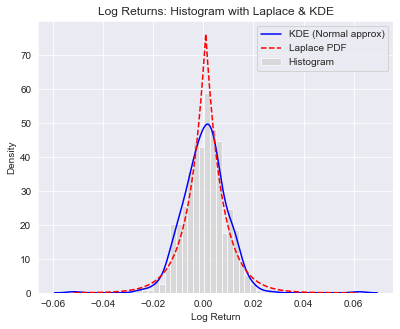

In [25]:
# Plot histogram and Laplace PDF
x = np.linspace(log_returns.min(), log_returns.max(), 1000)
pdf_laplace = laplace.pdf(x, loc=loc, scale=scale)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(log_returns, bins=50, stat="density", color='lightgray', label='Histogram')
sns.kdeplot(log_returns, color='blue', label='KDE (Normal approx)')
plt.plot(x, pdf_laplace, 'r--', label='Laplace PDF')
plt.title("Log Returns: Histogram with Laplace & KDE")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()

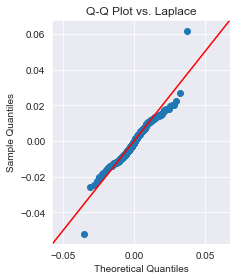

In [26]:
# Q-Q plot
plt.subplot(1, 2, 2)
sm.qqplot(log_returns, dist=laplace(loc, scale), line='45', ax=plt.gca())
plt.title("Q-Q Plot vs. Laplace")

plt.tight_layout()
plt.show()